# Import librairies

In [1]:
import os

seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)

import sys
import random

sys.path.append("../utile")
sys.path.append("..")
from database import create_cnx, config_parse
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

path = "../data"
plt.rcParams["figure.figsize"] = (15, 15)
import base64

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    Embedding,
    Concatenate,
    Flatten,
    Dense,
    Dropout,
)
from tensorflow.keras import Model, regularizers
from sklearn.cluster import KMeans
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import InputSpec

from model import Deep_Embedding_Model, DEC
from data import DataSet

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

2022-03-07 15:06:18.548370: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Using TensorFlow backend.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
print(tf.config.list_physical_devices())

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-03-07 15:06:21.803155: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-03-07 15:06:22.092956: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-07 15:06:22.093047: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 3060 Ti computeCapability: 8.6
coreClock: 1.665GHz coreCount: 38 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 417.29GiB/s
2022-03-07 15:06:22.093149: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-03-07 15:06:22.555329: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-03-07 15:06:22.555496: I tensorflow/stream_exec

# Loading data and utile functions

## Loading data from database

In [5]:
# Select the data for a given season
season = "rabi"
parser = config_parse()
cnx = create_cnx(parser)["cnx"]
curs = cnx.cursor()
sql_request = (
    f"""SELECT DISTINCT * from data_SCOR WHERE Season = "{season}" ORDER BY RAND() """
)
curs.execute(sql_request)
names = [x[0] for x in curs.description]
rows = curs.fetchall()
df = pd.DataFrame(rows, columns=names)
# Drop id column and columns that are completly empty
df.drop("id", inplace=True, axis=1)
df.dropna(axis=0, how="all", inplace=True)

In [6]:
print(len(df))

410997


# Data aumgentation for under represented features (here applied for block)

This part is not mandatory for the run of the model

In [6]:
# Define the minimum threshold needed for the model to learn
nb_min_repres = 40
# Take under represented rows
under_represented_blocks = (
    df["Block"]
    .value_counts()[df["Block"].value_counts() < nb_min_repres]
    .keys()
    .tolist()
)

__Here we add some slighlty noisy values for data augmentation. This approach is not totally rigourous because we add for each "under represented element" a slightly noisy row according to normal distribution which average and std are wrt one unique row (it would be better to group the dataset by locations (e.g States, District, Sub-district, Block) and take the average and a fraction of std of numeric features, and for categorical features a random values wrt to the frequency within all rows of the grouped location. Nevrtheless, because of performances issues, we didn't find a proper and efficient way to implement it.__ 

In [7]:
# Define numeric and textual features
numeric_features = [
    "Area_Sown_Ha",
    "Area_Insured_Ha",
    "SI_Per_Ha_Inr_Ha",
    "Sum_Insured_Inr",
    "Indemnity_Level",
]
textual_features = [
    "District",
    "Sub_District",
    "Crop",
    "Block",
    "State",
    "Cluster",
]


def add_noise(x):
    # Take normal sample for each row with the mean of the raw and std of a fraction of the mean
    x[numeric_features] = np.random.normal(
        loc=x[numeric_features].mean(), scale=0.05 * x[numeric_features].mean()
    )
    # print()
    return x


ohe_features = None
# df = df[numeric_features+textual_features]

# Convert numeric features to numeric (they are strings in the database)
df[numeric_features] = df[numeric_features].apply(pd.to_numeric)

# For every under reprensented block
for i, block in enumerate(under_represented_blocks):
    if i % 100 == 0:
        print(i)
    # Take the part of the dataset with the given block
    inter_df = df[df["Block"] == block][set(df.columns) - set(["Block"])]
    if not inter_df.empty:

        nb_r = len(inter_df)
        # Deduplicate the dataset
        inter_df = pd.DataFrame(
            np.repeat(inter_df.values, 1 + nb_min_repres // nb_r, axis=0),
            columns=inter_df.columns,
        )
        # Add slight randomness to each raw
        inter_df[numeric_features] = inter_df[numeric_features].apply(
            lambda x: add_noise(x), axis=1
        )
        df = df[df["Block"] != block]
        # Reconcatenate to the dataframe
        df = df.append(inter_df, ignore_index=True)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300


In [8]:
len(df)

858605

# Load class custom dataset

In [7]:
numeric_features = [
    # "Area_Sown_Ha",
    # "Area_Insured_Ha",
    "SI_Per_Ha_Inr_Ha",
    # "Sum_Insured_Inr",
    # "Indemnity_Level",
]
textual_features = [
    "District",
    "Sub_District",
    "Crop",
    "Block",
    "State",
    # "Cluster",
]

# Load custom dataset to apply some preprocessing and encoding
df = DataSet(
    numeric_features=numeric_features,
    textual_features=textual_features,
    data=df,
    columns=df.columns,
)
# df = pd.DataFrame(rows, columns=names)

# df.drop(axis=1,labels='index', inplace=True)
print(len(df))

410997


/appli/notebooks/../utile/data.py:63: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.numeric_features = numeric_features
/appli/notebooks/../utile/data.py:64: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.textual_features = textual_features
/appli/notebooks/../utile/data.py:66: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.values_list_to_replace = values_list_to_replace


# Preprocessing and encoding

## Pre-processing

In [8]:
# Keep only crop yields years with enough data
df.set_years_to_keep(drop=False)
# Subset dataframe to keep only numeric features, textual features, and crop yields years
df.subset_data()
# Preprocess numeric features
df.pre_process_numeric()
# Preprocess textual features
df.preprocess_textual()

{'2007_Yield': 3458.5794816695725, '2008_Yield': 3417.847702131436, '2009_Yield': 3884.756365521783, '2010_Yield': 3835.378456503959, '2011_Yield': 3885.5401339173136, '2012_Yield': 3912.1565515641096, '2013_Yield': 3590.0603680096465, '2014_Yield': 3451.467334080907}


/appli/notebooks/../utile/data.py:101: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.years_crop_yields = [f"{year}_Yield" for year in years_to_keep]
/appli/notebooks/../utile/data.py:171: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  indx_non_null_other = reduce(


In [9]:
len(df)

410997

## Encoding

In [10]:
# Set the shape of each embedding dictionnary
df.set_dict_shape()
# Encode OHE feature
df.encode_ohe()
# Encode textual feature
df.encode_textual()

dict_shape = df.dict_shape

/appli/notebooks/../utile/data.py:219: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.dict_shape = dict_shape
/appli/notebooks/../utile/data.py:256: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.vocab = vocab


# Regression Model

In [11]:
# Define model
from model import Deep_Embedding_Model

Dense_embedding_model = Deep_Embedding_Model(
    dict_shape=dict_shape,
    textual_features=textual_features,
    numeric_features=numeric_features,
    outputs_shape=len(df.years_crop_yields),
).model()

2022-03-07 15:07:42.044833: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-07 15:07:42.047361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-07 15:07:42.047434: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 3060 Ti computeCapability: 8.6
coreClock: 1.665GHz coreCount: 38 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 417.29GiB/s
2022-03-07 15:07:42.047972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/b

In [12]:
# If you want to resave plot of the model
# tf.keras.utils.plot_model(
#     Dense_embedding_model,
#     to_file="../material/images/Dense_embedding_model.png",
#     show_shapes=True,
#     show_layer_names=True,
# )

In [13]:
df.head()

,State,District,Sub_District,Block,Crop,SI_Per_Ha_Inr_Ha,2007_Yield,2008_Yield,2009_Yield,2010_Yield,2011_Yield,2012_Yield,2013_Yield,2014_Yield
0,7,114,1608,7806,55,-1.231500,2626.000000,2207.000000,2838.000000,2248.0,3012.5,2868.000000,2610.000000,3095.000000
1,7,92,3981,7806,55,-1.152428,920.000000,2082.000000,1933.000000,2280.0,2594.0,2884.000000,2555.000000,2160.000000
2,10,451,1972,8377,54,-0.528682,2280.429932,1906.400024,2280.399902,2394.0,3323.0,2144.399902,2156.600098,2235.199951
3,13,9,4508,7215,54,-0.353450,2052.000000,3088.000000,1940.000000,1821.0,2769.0,2576.000000,2475.000000,1317.000000
4,13,35,4406,5079,54,0.041383,2666.000000,2159.000000,2557.000000,3115.0,3502.0,3327.000000,2514.000000,1533.000000


## Model train and test

In [14]:
# Train/ test split
inputs = df.df_train_test_split()
inputs_train = [
    inputs["textual"]["train"],
    inputs["numeric"]["train"],
    # input_ohe_dict_train,
]
inputs_test = [
    inputs["textual"]["test"],
    inputs["numeric"]["test"],
    # input_ohe_dict_train,
]

# Train the model
epochs = 150
history = Dense_embedding_model.fit(
    inputs_train,  #
    inputs["label"]["train"],
    epochs=epochs,
    batch_size=2048,
    validation_split=0.3,
    validation_data=(inputs_test, inputs["label"]["test"]),
    verbose=1,
)

2022-03-07 15:07:43.601949: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-07 15:07:43.602554: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2496005000 Hz


Epoch 1/150


2022-03-07 15:07:44.211618: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-03-07 15:08:15.381440: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-03-07 15:08:15.381936: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


99/99 [==============================] - 38s 19ms/step - loss: 26169690.0000 - mae: 2443.5769 - val_loss: 6358778.5000 - val_mae: 994.0585
Epoch 2/150
99/99 [==============================] - 1s 15ms/step - loss: 5089622.5000 - mae: 957.5168 - val_loss: 4236864.5000 - val_mae: 859.9301
Epoch 3/150
99/99 [==============================] - 1s 15ms/step - loss: 4033586.2500 - mae: 907.4457 - val_loss: 3624266.5000 - val_mae: 826.2975
Epoch 4/150
99/99 [==============================] - 1s 15ms/step - loss: 3823740.7500 - mae: 892.2428 - val_loss: 3526243.5000 - val_mae: 821.8382
Epoch 5/150
99/99 [==============================] - 1s 15ms/step - loss: 3702539.5000 - mae: 889.5113 - val_loss: 3415000.7500 - val_mae: 820.9424
Epoch 6/150
99/99 [==============================] - 2s 16ms/step - loss: 3505491.5000 - mae: 874.8779 - val_loss: 3238932.0000 - val_mae: 798.9268
Epoch 7/150
99/99 [==============================] - 1s 15ms/step - loss: 3386894.5000 - mae: 869.0756 - val_loss: 314535

In [15]:
# Test the model
inputs_test = [
    inputs["textual"]["test"],
    inputs["numeric"]["test"],
    # input_ohe_dict_train,
]
Dense_embedding_model.evaluate(inputs_test, inputs["label"]["test"])
#

3854/3854 [==============================] - 30s 8ms/step - loss: 990986.8125 - mae: 396.6645


[990986.8125, 396.6644592285156]

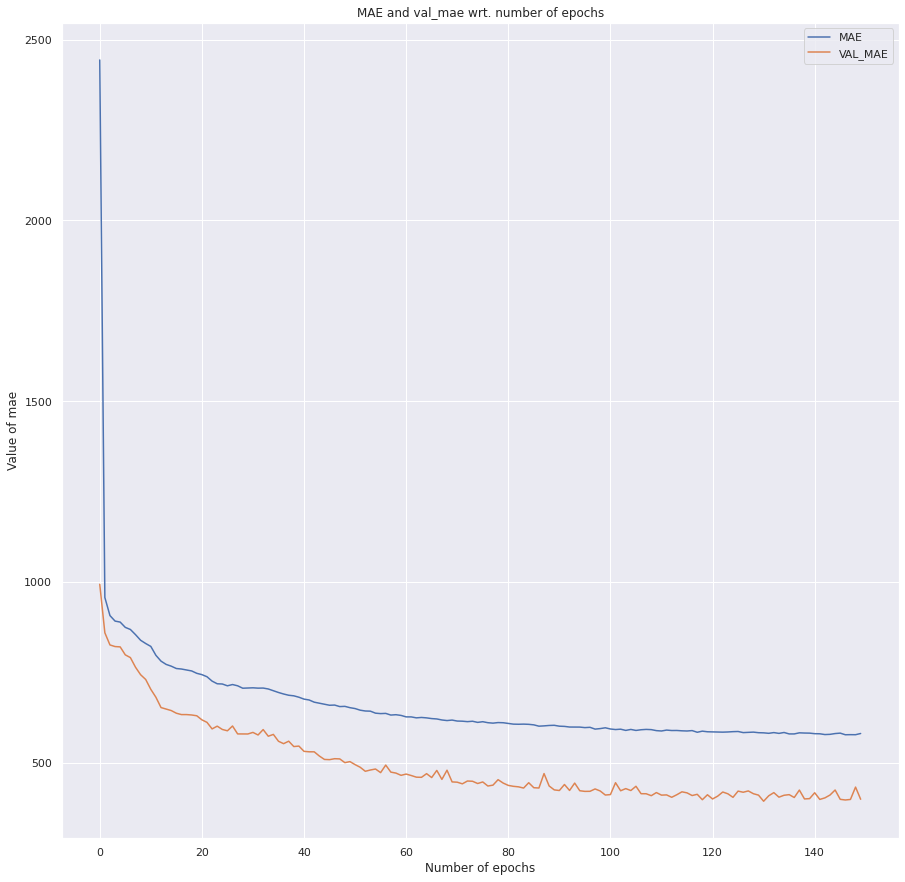

In [16]:
# Plot the training/val losses during training
sns.set_theme()
plt.plot(history.history["mae"], label="MAE")
plt.ylabel("Value of mae")
plt.xlabel("Number of epochs")
# ticks = plt.xticks(np.arange(1, epochs+1))
plt.plot(history.history["val_mae"], label="VAL_MAE")
plt.title("MAE and val_mae wrt. number of epochs")
plt.legend()

In [17]:
# Display average and std of crop yields we want to predict
print(df[df.years_crop_yields].mean())
print()
print(df[df.years_crop_yields].std())

2007_Yield    3458.579834
2008_Yield    3417.847900
2009_Yield    3884.757080
2010_Yield    3835.378662
2011_Yield    3885.540527
2012_Yield    3912.156006
2013_Yield    3590.060303
2014_Yield    3451.467041
dtype: float32

2007_Yield    5793.324707
2008_Yield    5385.632324
2009_Yield    6772.699219
2010_Yield    6477.141602
2011_Yield    6301.543457
2012_Yield    6380.501953
2013_Yield    5858.584961
2014_Yield    6161.497070
dtype: float32


In [18]:
list_embedding_clustering = {}
# Textual feature we want to keep for the clustering space
textual_features_to_keep = ["State", "District", "Sub_District", "Block"]
for feature in textual_features_to_keep:
    # Get trained embedding layer and apply it to the input
    list_embedding_clustering[feature] = Flatten()(
        Dense_embedding_model.get_layer(f"Embedding_{feature}")(
            Dense_embedding_model.input[0][feature]
        )
    )
# If there are several features, concatenate all embeddings
concatted_clustering = Concatenate(name="concatted_clustering")(
    list(list_embedding_clustering.values())
)

# Define the model for the projection of data onto clustering space
model_feature_representation = Model(
    inputs=[
        {key: Dense_embedding_model.input[0][key] for key in textual_features_to_keep}
    ],
    outputs=concatted_clustering,
    name="model_feature_representation",
)

In [48]:
# !pip3 install tensorflow==2.3.1
# !pip3 install keras==2.4.0
# !pip3 install shap==0.36
# # se version is
# # Shap version is 0.36

In [49]:
# !pip3 install tensorflow==2.5.0
# !pip3 install shap==0.39.0

# # SHAP version is: 0.39.0
# Tensorflow version is: 2.5.0

In [50]:
# !pip3 install ipywidgets

In [51]:
# explainable_model = tf.compat.v1.keras.Model(explainable_model.input,outputs=explainable_model.output)

## Features importance observation

This section's aim is to try to understand which feature is important for the model thanks to shapeley library

For more information please check https://towardsdatascience.com/a-novel-approach-to-feature-importance-shapley-additive-explanations-d18af30fc21b and https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Multioutput%20Regression%20SHAP.html

In [47]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [ ]:
# Here we need to redefine the model (the custom model was way too much difficult to integrate to shap shapeley)
tf.compat.v1.disable_v2_behavior()
denses = [50]
inputs_explainable_model = [
    Input(shape=(1,), name=f"input_{feature}")
    for feature in textual_features + numeric_features
]
L_embeddings = {}
for i, feat in enumerate(textual_features):
    L_embeddings[feat] = Flatten(name=f"Flatten_{feat}")(
        Embedding(
            input_dim=df.dict_shape[feat],
            output_dim=20,
            input_length=(1,),
            name=f"Embedding_{feat}",
        )(inputs_explainable_model[i])
    )
# concat1 = Concatenate(name="concatted1")([list(L_embeddings.values())])
# list(self.embeddings.values())
#                 + [elem for inpt in self.input[1:-1] for elem in inpt.values()]
concat = Concatenate(name="concatted")(
    list(L_embeddings.values()) + inputs_explainable_model[len(textual_features) :]
)
x = Dense(100, name="Dense_0")(concat)
for i, dense in enumerate(denses):
    x = Dense(dense, name=f"Dense_{i+1}")(x)
    x = Dropout(0.2)(x)
output = Dense(len(df.years_crop_yields))(x)
explainable_model = Model(
    inputs=inputs_explainable_model, outputs=output, name="explainable_model"
)

In [46]:
explainable_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss="mse",
    metrics=["mae"],
)
test_arr = df[textual_features + numeric_features].to_numpy()
explainable_model.fit(
    [test_arr[:, i] for i in range(len(textual_features + numeric_features))],
    df[df.years_crop_yields],
    epochs=450,
    batch_size=2048,
)

Train on 410997 samples
Epoch 1/450
410997/410997 [==============================] - 3s 7us/sample - loss: 14831738.9778 - mean_absolute_error: 1657.9990
Epoch 2/450
410997/410997 [==============================] - 3s 7us/sample - loss: 4267198.9088 - mean_absolute_error: 935.9139
Epoch 3/450
410997/410997 [==============================] - 3s 7us/sample - loss: 4182407.0697 - mean_absolute_error: 930.3944
Epoch 4/450
410997/410997 [==============================] - 3s 7us/sample - loss: 4163559.1732 - mean_absolute_error: 931.9236
Epoch 5/450
410997/410997 [==============================] - 3s 8us/sample - loss: 4182604.5356 - mean_absolute_error: 932.6227
Epoch 6/450
410997/410997 [==============================] - 3s 7us/sample - loss: 4145038.3377 - mean_absolute_error: 930.9642
Epoch 7/450
410997/410997 [==============================] - 3s 7us/sample - loss: 4167536.9832 - mean_absolute_error: 931.8434
Epoch 8/450
410997/410997 [==============================] - 3s 7us/sample - l

KeyboardInterrupt: 

In [55]:
# Set the explainer using the Kernel Explainer (Model agnostic explainer method form SHAP).
explainer = shap.DeepExplainer(
    explainable_model,
    [
        np.expand_dims(test_arr[random.sample(list(np.arange(len(df))), 150), i], 1)
        for i in range(len(textual_features + numeric_features))
    ],
)

In [56]:
# Get label (output) to analyze
import ipywidgets as widgets

list_of_labels = df[df.years_crop_yields].columns.tolist()

# Create a list of tuples so that the index of the label is what is returned
tuple_of_labels = list(zip(list_of_labels, range(len(list_of_labels))))

# Create a widget for the labels and then display the widget
current_label = widgets.Dropdown(
    options=tuple_of_labels, value=7, description="Select Label:"
)

In [63]:
# tf.compat.v1.disable_v2_behavior()
# import tensorflow.compat.v1.keras.backend as K
# tf.compat.v1.disable_eager_execution()
# import tensorflow.compat.v1.keras.backend as K
# import tensorflow as tf
# tf.compat.v1.disable_v2_behavior()
# tf.compat.v1.disable_eager_execution()
# Get shape values
shap_values = explainer.shap_values(
    X=[
        np.expand_dims(test_arr[random.sample(list(np.arange(len(df))), 400), i], 1)
        for i in range(len(textual_features + numeric_features))
    ]
)

Current Label Shown: 2014_Yield



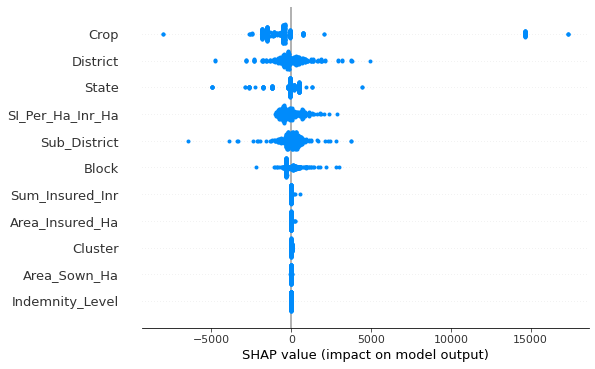

In [64]:
# Create the summary plot for a specific output/label/target.
shap.initjs()
print(f"Current Label Shown: {list_of_labels[current_label.value]}\n")
shap.summary_plot(
    shap_values=np.array(shap_values[current_label.value])[:, :, 0].T,
    features=[
        np.expand_dims(test_arr[:, i], 1)[0][0]
        for i in range(len(textual_features + numeric_features))
    ],
    feature_names=textual_features + numeric_features,
    # plot_type = "violin"
)

Current Label Shown: 2014_Yield



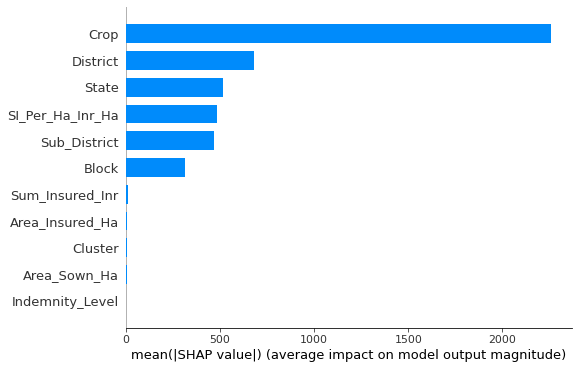

In [66]:
print(f"Current Label Shown: {list_of_labels[current_label.value]}\n")
shap.summary_plot(
    shap_values=np.array(shap_values[current_label.value])[:, :, 0].T,
    features=[
        np.expand_dims(test_arr[:, i], 1)[0][0]
        for i in range(len(textual_features + numeric_features))
    ],
    feature_names=textual_features + numeric_features,
    plot_type="bar",
)

# CLustering model only with embedding of states district etc.

The parts 7-8-9 are not needed to be run if you want to run cluster directly on the data for clustering, it is mostly to display results

In [47]:
# Apply embedding projection model to the input
X_train_embedded = model_feature_representation.predict([inputs["textual"]["train"]])
inputs_total = {}
for key in textual_features_to_keep:
    inputs_total[key] = np.array(
        [*inputs["textual"]["train"][key], *inputs["textual"]["test"][key]]
    )
X_train_embedded = model_feature_representation.predict([inputs_total])

# Take only unique values for the clustering (there are several times the same location in the dataset so we just keep one point for each location)
uniques = np.unique(X_train_embedded, axis=0)

2022-03-06 16:16:50.587084: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 126117440 exceeds 10% of free system memory.
2022-03-06 16:17:21.821968: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 180168000 exceeds 10% of free system memory.


In [15]:
nb_clusters = 6
model_kmeans = KMeans(nb_clusters).fit(uniques)
y_pred = model_kmeans.predict(uniques)

In [ ]:
# Get Davies Bouldin index for each number of cluster
davies_bouldin_scores = []
for k in range(2, 20):
    model_kmeans = KMeans(k).fit(uniques)
    davies_bouldin_scores.append(
        davies_bouldin_score(uniques, model_kmeans.predict(uniques))
    )

In [ ]:
# Display the value of the index wrt. the number of clusters
sns.set_theme()
plt.plot(np.arange(2, 20), davies_bouldin_scores)
plt.title("Plot of the value of Davies bouldin score wrt. number of clusters")
ticks = plt.xticks(np.arange(2, 20))

# Deep Embedding Clustering(DEC )

In [ ]:
# Define DEC model
DEC_model = DEC(dims=[uniques.shape[1]])
DEC_model.encoder_models()

In [ ]:
# Train AE
history = DEC_model.model_AE.fit(
    uniques,
    uniques,
    epochs=150,
    batch_size=128,
    validation_split=0.3,
)

In [ ]:
# Visualize training
sns.set_theme()
plt.plot(history.history["mae"], label="MAE")
plt.ylabel("Value of mae")
plt.xlabel("Number of epochs")
# ticks = plt.xticks(np.arange(1, epochs+1))
plt.plot(history.history["val_mae"], label="VAL_MAE")
plt.title("MAE and val_mae wrt. number of epochs")
plt.legend()

In [ ]:
# Get encodings from inputs
features = DEC_model.model_Encoder.predict(uniques)

In [ ]:
# Apply a Kmeans to visualize quickly results from AE
alpha = 0
n_clusters = 5
input_dim = 2
model_kmeans = KMeans(n_clusters).fit(features)
centroids_init = model_kmeans.cluster_centers_
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)
plt.scatter(pca_features[:, 0], pca_features[:, 1])

In [ ]:
plt.scatter(
    pca_features[:, 0], pca_features[:, 1], c=model_kmeans.labels_.astype(float)
)

In [ ]:
# See the repartition of the labels
pd.Series(model_kmeans.labels_).value_counts()

In [ ]:
# Print davies bouldin index
davies_bouldin_score(features, model_kmeans.predict(features))

In [ ]:
# DEC_model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
# Fine tune DEC
DEC_model.compile(optimizer="Adam", loss="kld")
y_pred, p, q, x = DEC_model.fit(x=uniques, n_clusters=6)

In [ ]:
# Print davies bouldin index
davies_bouldin_score(q, y_pred)

In [ ]:
# Visualize results
pca = PCA(n_components=2)
pca_q = pca.fit_transform(q)
plt.scatter(pca_q[:, 0], pca_q[:, 1], c=y_pred)

In [ ]:
# See the repartition of the labels
pd.DataFrame(y_pred).value_counts()

# Save models

In [ ]:
# import pickle
# from pathlib import Path

# parent_dir = os.path.abspath(os.path.join(path, os.pardir))
# pathdir = Path(
#     os.path.join(parent_dir, "pre_trained_models/feature_encoding", "vocab.pkl")
# )
# with pathdir.open("wb") as f:
#     pickle.dump(vocab, f)
# model_feature_representation.save("../pre_trained_models/feature_representation")
# model_dec.save("../pre_trained_models/DEC")
# model_AE.save("../pre_trained_models/AE")
# Dense_embedding_model.save("../pre_trained_models/dense_embedding")

# Clusterize data of predict file

## Import and match data

In [19]:
# Open file to predict and the fuzzy matching file to match files
path = os.path.join("..", "03_Prediction", f"GP_Pred_{season.title()}_ID.csv")
df_to_predict = pd.read_csv(path)
df_to_predict = df_to_predict.rename(columns={"Sub-District": "Sub_District"})

df_fuzzy_match = pd.read_csv(f"../material/files/fuzzy_match_{season}.csv")
df_fuzzy_match.drop(columns=["Unnamed: 0"], inplace=True)

In [24]:
# Match files function
def match(x, n):
    x = str(x)
    L = x.split("/sep/")
    try:
        return L[n]
    except:
        return "None"


# Define locations features needed to run predictions
df_fuzzy_match["State"] = df_fuzzy_match["loc_string_right"].apply(
    lambda x: match(x, 0)
)
df_fuzzy_match["District"] = df_fuzzy_match["loc_string_right"].apply(
    lambda x: match(x, 1)
)
df_fuzzy_match["Sub_District"] = df_fuzzy_match["loc_string_right"].apply(
    lambda x: match(x, 2)
)
df_fuzzy_match["Block"] = df_fuzzy_match["loc_string_right"].apply(
    lambda x: match(x, 3)
)
df_fuzzy_match = df_fuzzy_match.replace("None", "unknown")
df_fuzzy_match = df_fuzzy_match.replace(np.NAN, "unknown")
df_fuzzy_match = df_fuzzy_match.replace("nan", "unknown")

In [26]:
# Encode locations
df_fuzzy_match["State_encoded"] = df_fuzzy_match["State"].apply(
    lambda x: df.vocab["State"][x]
)
df_fuzzy_match["District_encoded"] = df_fuzzy_match["District"].apply(
    lambda x: df.vocab["District"][x]
)
df_fuzzy_match["Sub_District_encoded"] = df_fuzzy_match["Sub_District"].apply(
    lambda x: df.vocab["Sub_District"][x]
)
df_fuzzy_match["Block_encoded"] = df_fuzzy_match["Block"].apply(
    lambda x: df.vocab["Block"][x]
)

## Project onto embedding space

In [28]:
# Apply projection onto embedding space
data_prediction = df_fuzzy_match[
    ["State_encoded", "District_encoded", "Sub_District_encoded", "Block_encoded"]
].rename(
    columns={
        "State_encoded": "State",
        "District_encoded": "District",
        "Sub_District_encoded": "Sub_District",
        "Block_encoded": "Block",
    }
)
data_prediction_dict = {
    key: data_prediction[key].to_numpy() for key in data_prediction.keys()
}

X_embedded_fuzzy = model_feature_representation.predict(data_prediction_dict)

## KMeans without DEC

In [52]:
# To run only if you want to run K means directly on embeddings with normalized vector
X_embedded_fuzzy /= np.linalg.norm(
    X_embedded_fuzzy, axis=1, keepdims=True
)  # To run if you want cosine similarity rather than distance
n_clusters = 8
model_kmeans = KMeans(n_clusters).fit(X_embedded_fuzzy)
y_pred = pd.Series(model_kmeans.labels_)

## DEC model

In [45]:
# If you want to run the model with DEC
# Define DEC model
DEC_model = DEC(dims=[X_embedded_fuzzy.shape[1]], n_clusters=9)
DEC_model.encoder_models()
# Train AE
history = DEC_model.model_AE.fit(
    X_embedded_fuzzy,
    X_embedded_fuzzy,
    epochs=200,
    batch_size=128,
    validation_split=0.3,
)

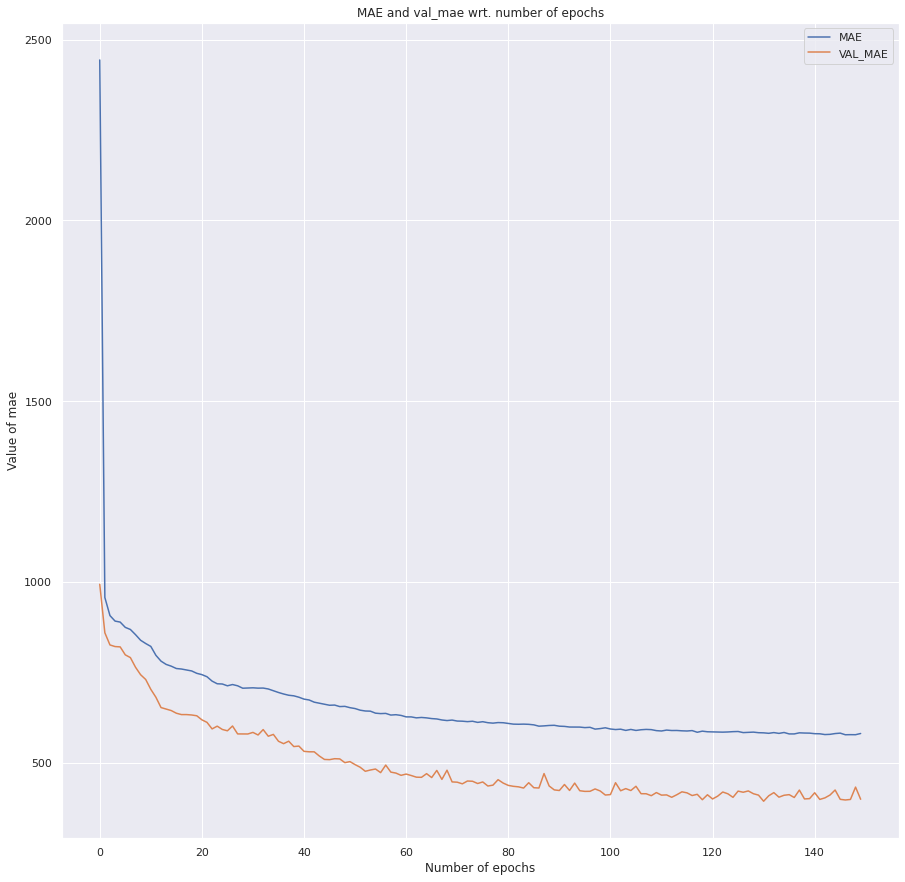

In [33]:
# Visualize training
sns.set_theme()
plt.plot(history.history["mae"], label="MAE")
plt.ylabel("Value of mae")
plt.xlabel("Number of epochs")
# ticks = plt.xticks(np.arange(1, epochs+1))
plt.plot(history.history["val_mae"], label="VAL_MAE")
plt.title("MAE and val_mae wrt. number of epochs")
plt.legend()

In [34]:
# Get encodings from inputs
features = DEC_model.model_Encoder.predict(X_embedded_fuzzy)

In [36]:
# Get Davies Bouldin index for each number of cluster
davies_bouldin_scores = []
for k in range(2, 20):
    model_kmeans = KMeans(k).fit(features)
    davies_bouldin_scores.append(
        davies_bouldin_score(features, model_kmeans.predict(features))
    )

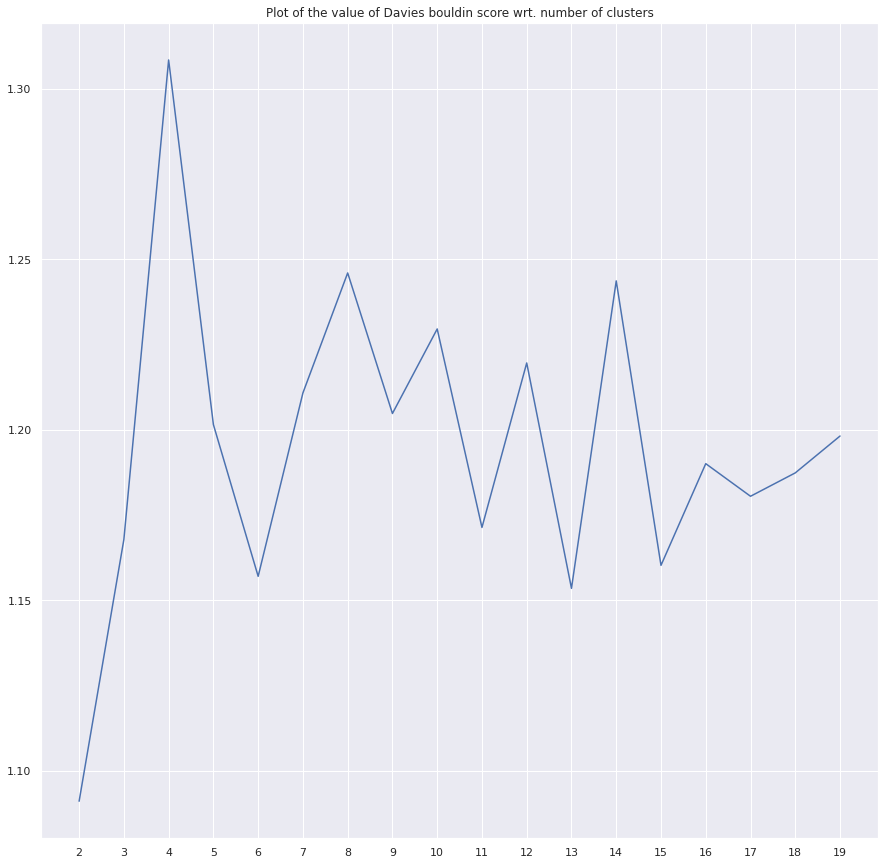

In [37]:
# Display the value of the index wrt. the number of clusters
sns.set_theme()
plt.plot(np.arange(2, 20), davies_bouldin_scores)
plt.title("Plot of the value of Davies bouldin score wrt. number of clusters")
ticks = plt.xticks(np.arange(2, 20))

In [38]:
# Apply a Kmeans to visualize quickly results from AE
alpha = 0
n_clusters = 9
input_dim = 2
model_kmeans = KMeans(n_clusters).fit(features)
centroids_init = model_kmeans.cluster_centers_

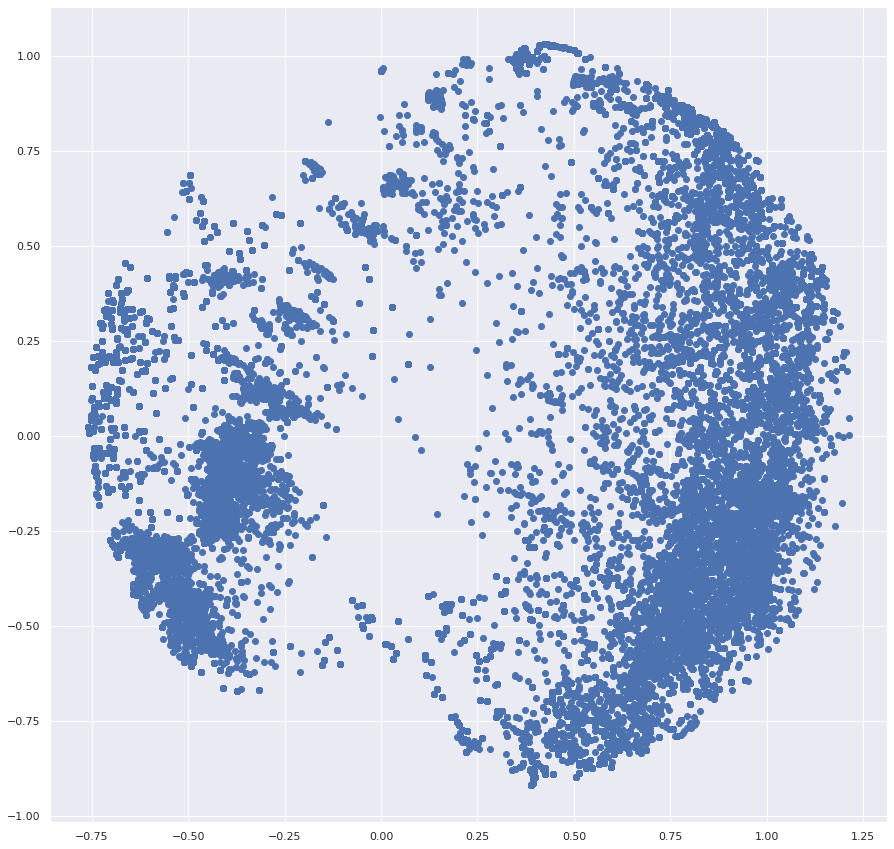

In [39]:
# Plot PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)
plt.scatter(pca_features[:, 0], pca_features[:, 1])

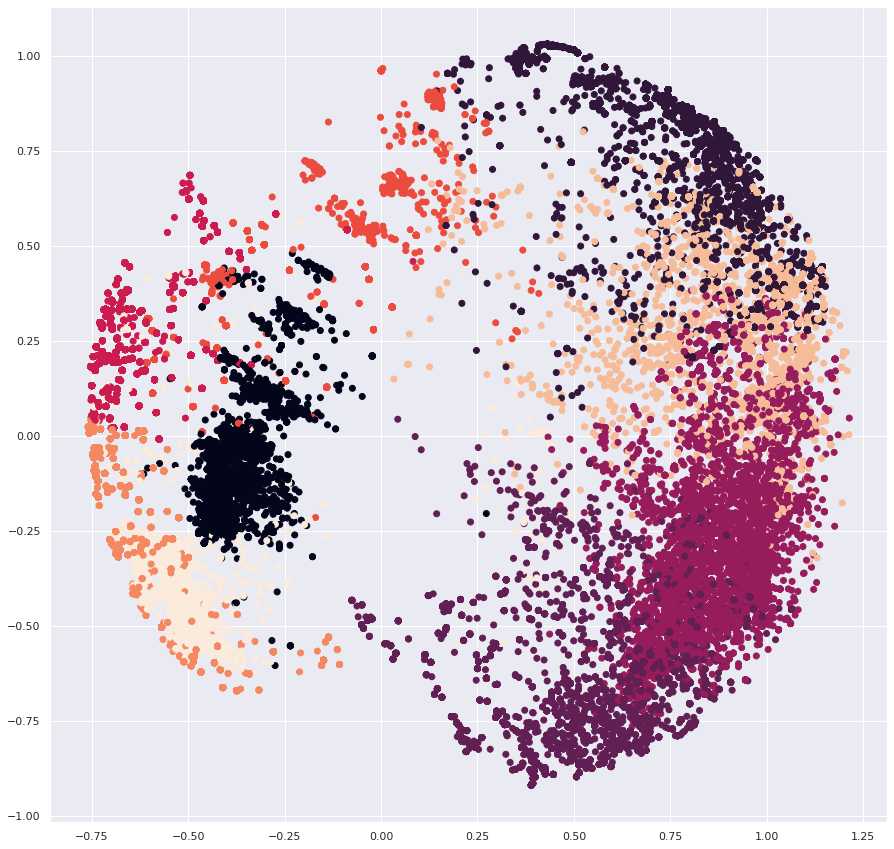

In [40]:
# Plot PCA with KMeans results
plt.scatter(
    pca_features[:, 0], pca_features[:, 1], c=model_kmeans.labels_.astype(float)
)

In [41]:
# Label repartition
pd.Series(model_kmeans.labels_).value_counts()

4    8890
6    7009
3    6092
2    4878
8    4862
1    4571
0    3236
7    3174
5    2458
dtype: int64

In [42]:
# Davies Bouldin index
davies_bouldin_score(features, model_kmeans.predict(features))

1.2007258176554347

In [43]:
# Fine tuning DEC
DEC_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss="kld")
y_pred, p, q, x = DEC_model.fit(x=X_embedded_fuzzy, n_clusters=9)
# SGD(0.0005, 0.005)

Loss value:0 for iteration 0
Loss value:0.14801806211471558 for iteration 1000
Loss value:0.10116186738014221 for iteration 2000
Loss value:0.20437230169773102 for iteration 3000
Loss value:0.260655015707016 for iteration 4000
Loss value:0.11112876236438751 for iteration 5000
Loss value:0.28382790088653564 for iteration 6000


KeyboardInterrupt: 

In [58]:
# Davies Bouldin index
davies_bouldin_score(q, y_pred)

0.37689359848405335

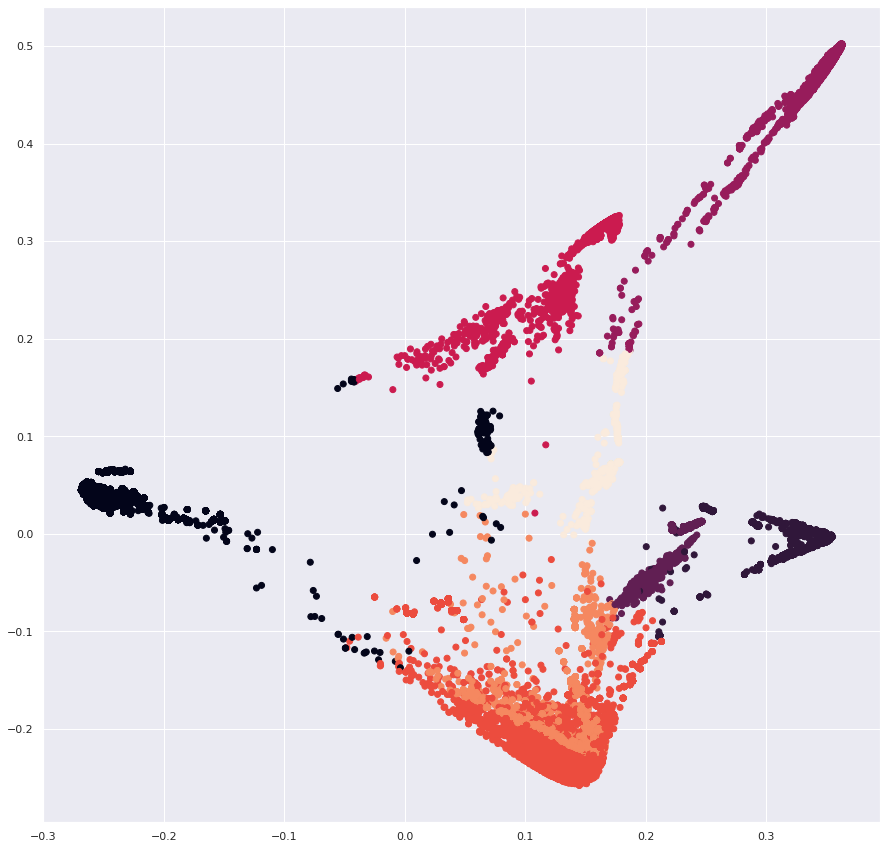

In [59]:
# Plot PCA with DEC results
pca = PCA(n_components=2)
pca_q = pca.fit_transform(q)
plt.scatter(pca_q[:, 0], pca_q[:, 1], c=y_pred)

In [60]:
# Repartition of the label
pd.DataFrame(y_pred).value_counts()

0    19098
5     9016
6     6277
4     3164
3     2923
1     2681
2     1288
8      723
dtype: int64

## Fill files with predictions

In [55]:
# Set prediction
df_fuzzy_match["cluster"] = y_pred
df_to_predict = df_to_predict.fillna("unknown")

# Set fuzzy file to match with predicitions
df_fuzzy_match["StateKey"] = df_fuzzy_match["loc_string_left"].apply(
    lambda x: match(x, 0)
)
df_fuzzy_match["DistrictKey"] = df_fuzzy_match["loc_string_left"].apply(
    lambda x: match(x, 1)
)
df_fuzzy_match["Sub_DistrictKey"] = df_fuzzy_match["loc_string_left"].apply(
    lambda x: match(x, 2)
)
df_fuzzy_match["BlockKey"] = df_fuzzy_match["loc_string_left"].apply(
    lambda x: match(x, 3)
)
df_fuzzy_match = df_fuzzy_match.replace("None", "unknown")
df_fuzzy_match = df_fuzzy_match.replace(np.NAN, "unknown")
df_fuzzy_match = df_fuzzy_match.replace("nan", "unknown")

In [58]:
# Join predictions files and the file we need to fill of predictions
df_join = df_to_predict.merge(
    df_fuzzy_match[
        ["StateKey", "DistrictKey", "Sub_DistrictKey", "BlockKey", "cluster"]
    ],
    how="left",
    right_on=["StateKey", "DistrictKey", "Sub_DistrictKey", "BlockKey"],
    left_on=["State", "District", "Sub_District", "Block"],
)
df_join = df_join[
    ["index", "key", "State", "District", "Sub_District", "Block", "GP", "cluster"]
]
df_join = df_join.rename(columns={"cluster": "Cluster"})
df_join = df_join.replace("unknown", "")

In [61]:
df_join.head()

,index,key,State,District,Sub_District,Block,GP,Cluster
0,0,andhra pradesh_anantapur_vidapanakal__,andhra pradesh,anantapur,vidapanakal,,,4859.0
1,1,andhra pradesh_anantapur_vajrakarur__,andhra pradesh,anantapur,vajrakarur,,,19628.0
2,2,andhra pradesh_anantapur_gooty__,andhra pradesh,anantapur,gooty,,,3800.0
3,3,andhra pradesh_anantapur_guntakal__,andhra pradesh,anantapur,guntakal,,,3342.0
4,4,andhra pradesh_anantapur_pamidi__,andhra pradesh,anantapur,pamidi,,,2109.0
...,...,...,...,...,...,...,...,...
226138,226138,uttar pradesh_agra_jaitpur kalan_kookapur_muku...,uttar pradesh,agra,jaitpur kalan,kookapur,mukutpura,
226139,226139,uttar pradesh_agra_khandauli_dhaurra_rahan khurd,uttar pradesh,agra,khandauli,dhaurra,rahan khurd,
226140,226140,uttar pradesh_agra_kheragarh_sitouli_khanpur,uttar pradesh,agra,kheragarh,sitouli,khanpur,
226141,226141,uttar pradesh_agra_pinahat_husainpura_ladhavapura,uttar pradesh,agra,pinahat,husainpura,ladhavapura,


In [62]:
# Export to csv
df_join.to_csv(f"../03_Prediction/predictions/predictions_{season}.csv")